In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Author: Xiaopeng Pan
# ID: 1129446
# Purpose: Assignment 2 Part 2
# Date: Mar 8, 2021

# import basic packages
import numpy as np
import matplotlib.pyplot as plt
import os                   # to list the images
import random
import datetime
import time

# to evaluate the performance
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,confusion_matrix

# import keras package to create the CNN model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers, Input
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, \
                                    Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

# import the libraries of DenseNet121
from tensorflow.keras.applications.densenet import DenseNet121

import warnings   # to disable warning
warnings.filterwarnings('ignore')     

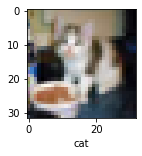

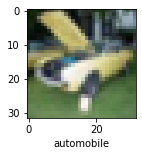

In [ ]:
# method to plot an image
def plot_img(X, y, classes):
  plt.figure(figsize = (15,2))
  plt.imshow(X)
  plt.xlabel(classes[int(y[0].item())])
  plt.show()

classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

# test the method
# from train set
img_path = r'/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/CIFAR10/cifar/TRAINSET/cat/TrainImage_1000.bmp'
img = image.load_img(img_path, target_size=(32, 32))
img_value = image.img_to_array(img)
img_value = np.expand_dims(img_value, axis=0)
img_label = np.array([3])

plot_img(img_value[0].astype(np.uint8),img_label,classes)

# from test set
img_path = r'/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/CIFAR10/cifar/TESTSET/automobile/TestImage_1000.bmp'
img = image.load_img(img_path, target_size=(32, 32))
img_value = image.img_to_array(img)
img_value = np.expand_dims(img_value, axis=0)
img_label = np.array([1])

plot_img(img_value[0].astype(np.uint8),img_label,classes)

In [ ]:
def build_dataset(data_path,X,y):
  if "TRAIN" in data_path:
    if os.path.exists("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_train_p2.npy") and \
       os.path.exists("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_train_p2.npy"):
      print("Train sets exist!")
      return
  elif "TEST" in data_path:
    if os.path.exists("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_test_p2.npy") and \
       os.path.exists("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_test_p2.npy"):
      print("Test sets exist!")
      return

  file_index = 0
  file_list = os.listdir(data_path)
  
  classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

  # read image data
  for c in file_list:
    data_path_2 = data_path + "/" + c
    file_list_2 = os.listdir(data_path_2)
    print("class '",c,"' in process...")
    for file_name in file_list_2:
      img_path = data_path_2 + "/" + file_name
      img = image.load_img(img_path, target_size=(32, 32))
      img_value = image.img_to_array(img)
      img_value = np.expand_dims(img_value, axis=0)
      img_value = img_value.astype(np.uint8)
      img_label = np.array([classes.index(c)])
      
      X[file_index] = img_value # assign image attribute values to X array
      y[file_index] = img_label

      if file_list_2.index(file_name) % 1000 == 0 or (file_list_2.index(file_name)+1) % 1000 == 0:
        plot_img(img_value[0],img_label,classes)
      if file_list_2.index(file_name) % 200 == 0:
        print("%5d"%(file_list_2.index(file_name)+1),end="")
      elif (file_list_2.index(file_name) +1) % 200 == 0:
        print("%5d"%(file_list_2.index(file_name)+1))
      else:
        print(".",end="")
      file_index = file_index + 1
    print(file_index,"images have been processed.")

  
  # save the extracted data
  if "TRAIN" in data_path:
    np.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_train_p2.npy",X)
    print("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_train_p2.npy saved.")
    np.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_train_p2.npy",y)
    print("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_train_p2.npy saved.")
  elif "TEST" in data_path:
    np.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_test_p2.npy",X)
    print("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_test_p2.npy saved.")
    np.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_test_p2.npy",y)
    print("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_test_p2.npy saved.")


In [ ]:
# generate the dataset to be processed
X_train = np.zeros((50000,32,32,3),dtype=np.uint8)
y_train = np.zeros((50000,1),dtype=np.uint8)
X_test = np.zeros((10000,32,32,3),dtype=np.uint8)
y_test = np.zeros((10000,1),dtype=np.uint8)

print("Building the train set")
print("-"*80)
data_path = r'/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/CIFAR10/cifar/TRAINSET'
build_dataset(data_path,X_train,y_train)
print("Building the test set")
print("-"*80)
data_path = r'/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/CIFAR10/cifar/TESTSET'
build_dataset(data_path,X_test,y_test)


Building the train set
--------------------------------------------------------------------------------
Train sets exist!
Building the test set
--------------------------------------------------------------------------------
Test sets exist!


train feature size: (50000, 32, 32, 3)
train label size: (50000, 1)
test feature size: (10000, 32, 32, 3)
test label size: (10000, 1)

Sanity test for train set:


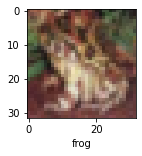

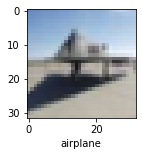

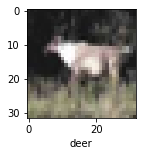

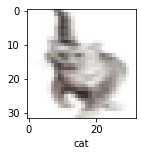

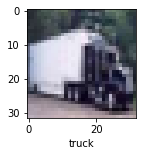

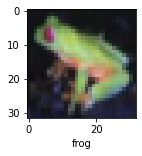

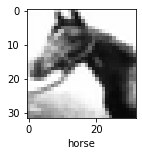

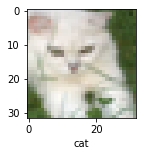

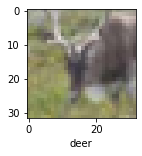

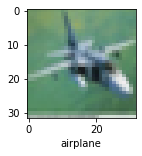


Sanity test for test set:


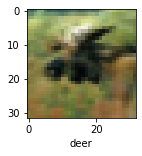

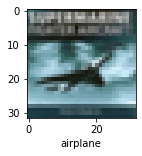

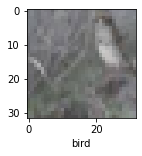

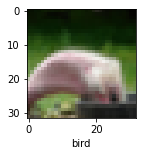

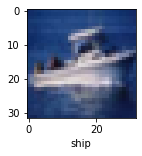

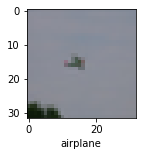

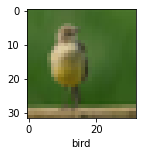

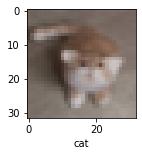

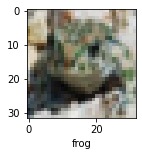

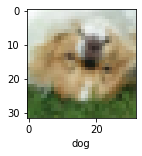

In [ ]:
# sanity test for the images
# load the saved datasets
X_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_train_p2.npy")
y_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_train_p2.npy")
X_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_test_p2.npy")
y_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_test_p2.npy")

print("train feature size:", X_train.shape)
print("train label size:", y_train.shape)
print("test feature size:", X_test.shape)
print("test label size:", y_test.shape)

# train set
import random
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

print()
print("Sanity test for train set:")
for i in range(10):
  idx = random.randint(0,X_train.shape[0]-1)
  img_value = X_train[idx]
  img_label = y_train[idx]
  plot_img(img_value,img_label,classes)
plt.show()

# test set

print()
print("Sanity test for test set:")
for i in range(10):
  idx = random.randint(0,X_test.shape[0]-1)
  img_value = X_test[idx]
  img_label = y_test[idx]
  plot_img(img_value,img_label,classes)
plt.show()

In [4]:
# shuffle the dataset by the first dimension (number of images)
def shuffle_by_row(X,y):
  import random
  row_num = [i for i in range(X.shape[0])]

  X_ = np.zeros_like(X)
  y_ = np.zeros_like(y)

  print("Shuffling dataset: ",end="")

  r_n = 0
  while len(row_num)>0:
    r_idx = random.randint(0, len(row_num)-1)
    X_[r_n] = X[row_num[r_idx]]
    y_[r_n] = y[row_num[r_idx]]
    row_num.remove(row_num[r_idx])
    if r_n % 10000 == 0:
      if r_n == 0:
        print("  %d"%(r_n), end="")
      else:
        print(" > %d"%(r_n), end="")
    r_n += 1
  print(" > %d\tDone!"%(r_n))
  return X_, y_

In [5]:
# plot loss and accuracies
def plot_loss_acc(acc_tr,acc_va,acc_te,loss,fig_w,fig_h):
  ep = [i for i in range(1,len(acc_tr)+1,1)]
  
  fig, ax1 = plt.subplots(figsize=(fig_w, fig_h))
  ax1.plot(ep, loss, color='tab:red')
  ax1.set_title('Loss and Accuracy')
  ax1.set_xticks(ep)
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.tick_params(axis='y')

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  ax2.plot(ep, acc_tr)
  ax2.plot(ep, acc_va)
  ax2.plot(ep, acc_te)
  ax2.set_ylabel('accuracy')  # we already handled the x-label with ax1
  ax2.legend(['training', 'validation', 'testing'], loc='upper right')
  ax2.tick_params(axis='y')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()

In [6]:
# load the saved datasets
def prepare_dataset():
  X_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_train_p2.npy")
  y_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_train_p2.npy")
  X_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_test_p2.npy")
  y_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_test_p2.npy")

  # shuffle the train dataset
  X_train, y_train = shuffle_by_row(X_train, y_train)

  # normalize the datasets
  X_train = X_train.astype(np.float32) / 255
  y_train = y_train.astype(np.float32)
  X_test = X_test.astype(np.float32) /255
  y_test = y_test.astype(np.float32)

  # Prepare the training dataset.
  batch_size = 256

  # Reserve 10,000 samples for validation.
  x_val = X_train[-10000:]
  y_val = y_train[-10000:]
  x_train = X_train[:-10000]
  y_train = y_train[:-10000]

  # Prepare the training dataset.
  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

  # Prepare the validation dataset.
  val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  val_dataset = val_dataset.batch(batch_size)

  return train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test

# Part 1  
Note: The low testing accuracy in the previous submission has been solved in this part.

In [18]:
# get the model
def get_model_p1():
    activation_function='relu'
    img_rows = 32
    img_cols = 32
    channel_number = 3

    model = Sequential()
    
    # 2 convolutional layers with names 'conv1', 'conv2'
    model.add(Conv2D(32, kernel_size = (5, 5), activation=activation_function, input_shape=(img_rows, img_cols, channel_number), name='conv1'))
    model.add(Conv2D(32, kernel_size = (5, 5), activation=activation_function, name='conv2'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    # 2 convolutional layers with names 'conv3', 'conv4'
    model.add(Conv2D(64, kernel_size=(3,3), activation=activation_function, name='conv3'))
    model.add(Conv2D(64, kernel_size=(3,3), activation=activation_function, name='conv4'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    # 1 convolutional layers with name 'conv5'
    model.add(Conv2D(128, kernel_size=(3,3), activation=activation_function, name='conv5'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    # 3 4 dense layers with names 'dens1', 'dens2', 'dens3', 'dens4'
    model.add(Flatten())
    model.add(Dense(128, activation=activation_function, name='dens1'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation=activation_function, name='dens2'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation=activation_function, name='dens3'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation = 'softmax', name='dens4'))
    model.summary()
    return model

In [20]:
# train the model and save loss and accuracies
def train_and_test_p1(model_cnn,train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test):
  epochs = 20
  loss = []
  acc_tr = []
  acc_va = []
  acc_te = []

  time_st = time.time()

  # Instantiate an optimizer.
  optimizer1 = keras.optimizers.Adam(learning_rate=0.1e-4)
  optimizer2 = keras.optimizers.Adam(learning_rate=0.5e-4)
  optimizer3 = keras.optimizers.Adam(learning_rate=1e-4)
  optimizer4 = keras.optimizers.Adam(learning_rate=5e-4)
  optimizer5 = keras.optimizers.Adam(learning_rate=10e-4)

  # Instantiate a loss function.
  loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  for epoch in range(epochs):
      
      print("Epoch #%3d\t"%(epoch+1),end="")

      # Iterate over the batches of the dataset.
      for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

          # Open a GradientTape to record the operations run during the forward pass, which enables auto-differentiation.
          with tf.GradientTape(persistent=True) as tape:

              # Run the forward pass of the layer. The operations that the layer applies to its inputs are going to be recorded on the GradientTape.
              logits = model_cnn(x_batch_train, training=True)  # Logits for this minibatch

              # Compute the loss value for this minibatch.
              loss_value = loss_fn(y_batch_train, logits)

          # Use the gradient tape to automatically retrieve the gradients of the trainable variables with respect to the loss.
          # grads = tape.gradient(loss_value, model_cnn.trainable_weights)

          # Run one step of gradient descent by updating the value of the variables to minimize the loss.
          # optimizer.apply_gradients(zip(grads, model_cnn.trainable_weights))

          # update weights of convolutional layers using different learning rates
          grads = tape.gradient(loss_value, model_cnn.get_layer('conv1').variables)
          optimizer1.apply_gradients(zip(grads, model_cnn.get_layer('conv1').variables))
          grads = tape.gradient(loss_value, model_cnn.get_layer('conv2').variables)   
          optimizer2.apply_gradients(zip(grads, model_cnn.get_layer('conv2').variables))
          grads = tape.gradient(loss_value, model_cnn.get_layer('conv3').variables)   
          optimizer3.apply_gradients(zip(grads, model_cnn.get_layer('conv3').variables))
          grads = tape.gradient(loss_value, model_cnn.get_layer('conv4').variables)   
          optimizer4.apply_gradients(zip(grads, model_cnn.get_layer('conv4').variables))
          grads = tape.gradient(loss_value, model_cnn.get_layer('conv5').variables)   
          optimizer5.apply_gradients(zip(grads, model_cnn.get_layer('conv5').variables))

          # update weights of dense layers using the same learning rates
          grads = tape.gradient(loss_value, model_cnn.get_layer('dens1').variables)   
          optimizer5.apply_gradients(zip(grads, model_cnn.get_layer('dens1').variables))
          grads = tape.gradient(loss_value, model_cnn.get_layer('dens2').variables)   
          optimizer5.apply_gradients(zip(grads, model_cnn.get_layer('dens2').variables))
          grads = tape.gradient(loss_value, model_cnn.get_layer('dens3').variables)   
          optimizer5.apply_gradients(zip(grads, model_cnn.get_layer('dens3').variables))
          grads = tape.gradient(loss_value, model_cnn.get_layer('dens4').variables)   
          optimizer5.apply_gradients(zip(grads, model_cnn.get_layer('dens4').variables))

      # output the loss after each epoch    
      print("Current loss: %f\t"%(loss_value),end="")
      loss.append(loss_value)

      # output the current training, validation, testing accuracies
      y_pred = model_cnn.predict(x_train)
      y_pred_classes = [np.argmax(y_p) for y_p in y_pred]
      train_accuracy = accuracy_score(y_train, y_pred_classes)
      print("Training Accuracy = %f\t"%(train_accuracy),end="")
      acc_tr.append(train_accuracy)
      

      y_pred = model_cnn.predict(x_val)
      y_pred_classes = [np.argmax(y_p) for y_p in y_pred]
      validation_accuracy = accuracy_score(y_val, y_pred_classes)
      print("Validation Accuracy = %f\t"%(validation_accuracy),end="")
      acc_va.append(validation_accuracy)

      y_pred = model_cnn.predict(X_test)
      y_pred_classes = [np.argmax(y_p) for y_p in y_pred]
      test_accuracy = accuracy_score(y_test, y_pred_classes)
      print("Testing Accuracy = %f\t"%(test_accuracy))
      acc_te.append(test_accuracy)

  print("\nTraining time:%f seconds\n"%(time.time()-time_st))

  # plot the loss and accuracies during training
  plot_loss_acc(acc_tr,acc_va,acc_te,loss,20,10)

  # save the trained model
  model_cnn.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_model_p1.h5")

  return train_accuracy, validation_accuracy, test_accuracy

Run 1
--------------------------------------------------------------------------------
Shuffling dataset:   0 > 10000 > 20000 > 30000 > 40000 > 50000	Done!
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_15 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (

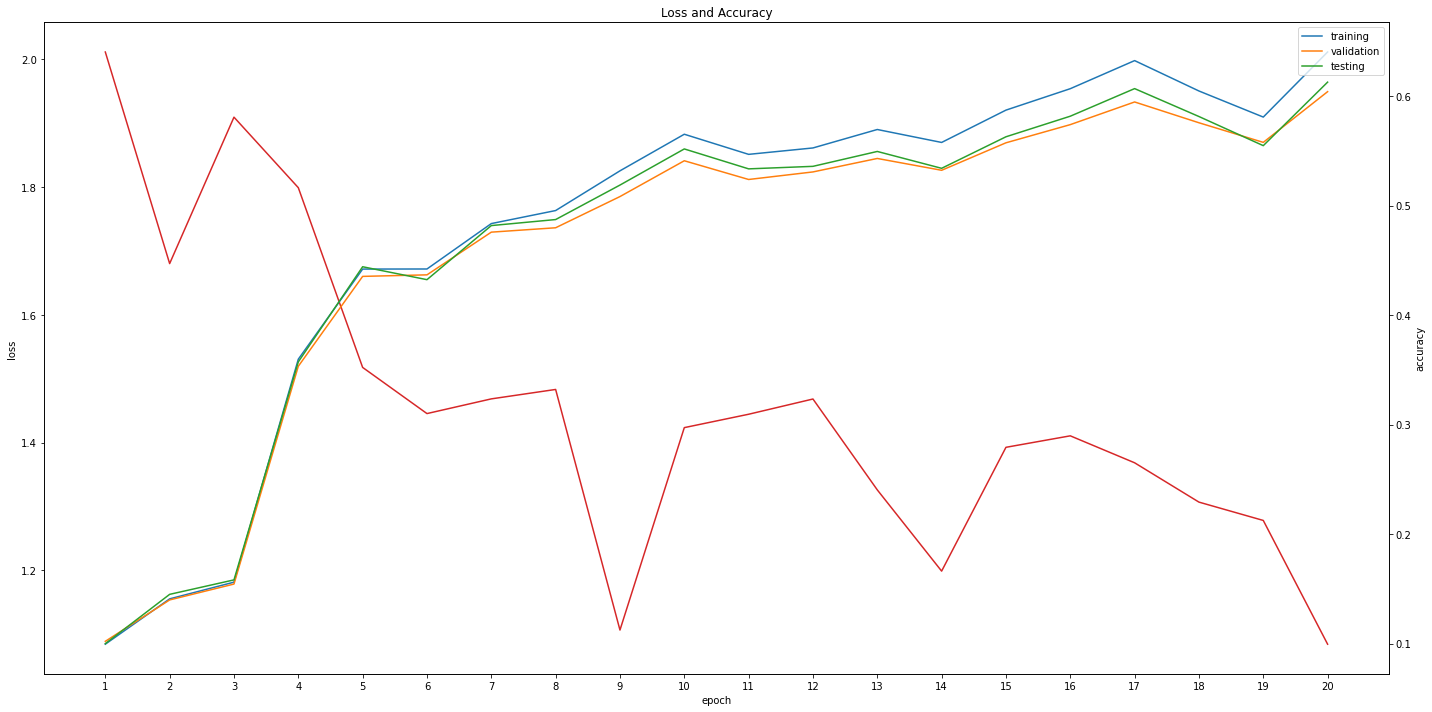

Run 2
--------------------------------------------------------------------------------
Shuffling dataset:   0 > 10000 > 20000 > 30000 > 40000 > 50000	Done!
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_20 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (

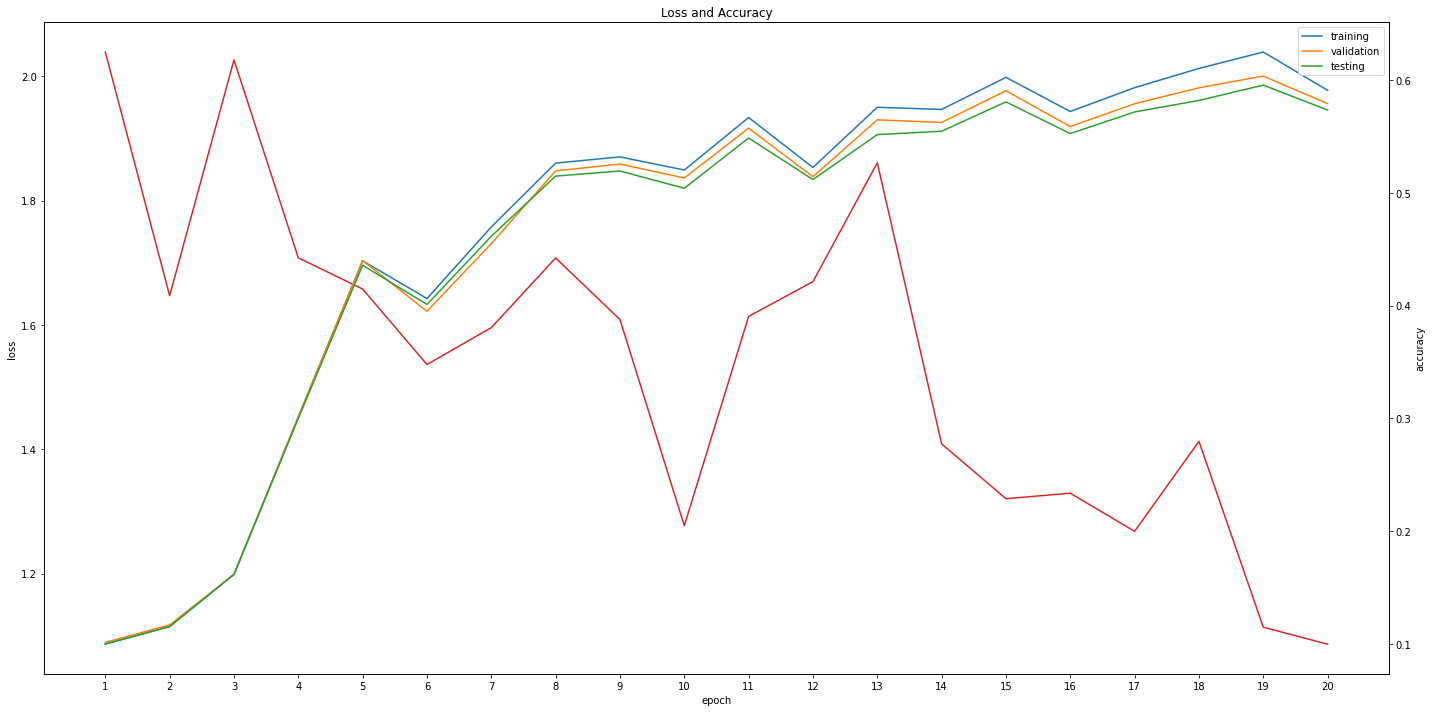

Run 3
--------------------------------------------------------------------------------
Shuffling dataset:   0 > 10000 > 20000 > 30000 > 40000 > 50000	Done!
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_25 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (

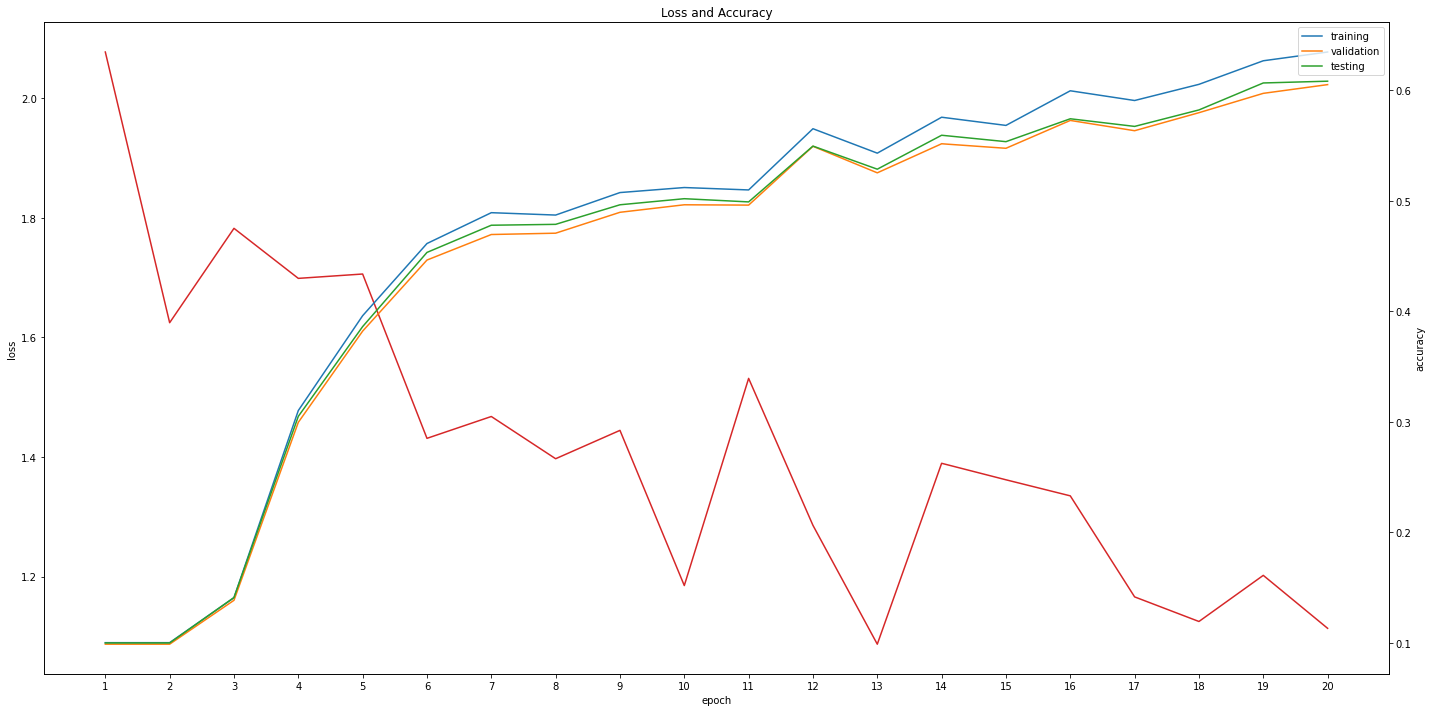

Results
--------------------------------------------------------------------------------
Average Training Accuracy: 0.6220083333333334, Average Validation Accuracy: 0.5961666666666666, Average Testing Accuracy: 0.5982


In [21]:
# run 3 times
print("Run 1")
print("-"*80)
# prepare the datasets
train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test = prepare_dataset()
# get the model
model_p1_run1 = get_model_p1()
# train and test
tr_acc_run_1, va_acc_run_1, te_acc_run_1 = train_and_test_p1(model_p1_run1, train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test)

print("Run 2")
print("-"*80)
# prepare the datasets
train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test = prepare_dataset()
# get the model
model_p1_run2 = get_model_p1()
# train and test
tr_acc_run_2, va_acc_run_2, te_acc_run_2 = train_and_test_p1(model_p1_run2, train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test)

print("Run 3")
print("-"*80)
# prepare the datasets
train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test = prepare_dataset()
# get the model
model_p1_run3 = get_model_p1()
# train and test
tr_acc_run_3, va_acc_run_3, te_acc_run_3 = train_and_test_p1(model_p1_run3, train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test)

print("Results")
print("-"*80)
print("Average Training Accuracy: {}, Average Validation Accuracy: {}, Average Testing Accuracy: {}".format((tr_acc_run_1+tr_acc_run_2+tr_acc_run_3)/3, (va_acc_run_1+va_acc_run_2+va_acc_run_3)/3, (te_acc_run_1+te_acc_run_2+te_acc_run_3)/3))


In [22]:
# load the saved datasets
X_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_train_p2.npy")
y_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_train_p2.npy")
X_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_test_p2.npy")
y_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_test_p2.npy")

# normalize the datasets
X_train = X_train.astype(np.float32) / 255
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32) /255
y_test = y_test.astype(np.float32)

# load the saved model
model_cnn = load_model("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_model_p1.h5")

# obtain the training accuracy
y_pred = model_cnn.predict(X_train)
y_pred_classes = [np.argmax(y_p) for y_p in y_pred]

print("For Training Dataset:")
print("Classification Report: \n", classification_report(y_train, y_pred_classes))
print("Training Accuracy =",accuracy_score(y_train, y_pred_classes))
print("Confusion Matrix =\n",confusion_matrix(y_train, y_pred_classes))

# obtain the testing accuracy
y_pred = model_cnn.predict(X_test)
y_pred_classes = [np.argmax(y_p) for y_p in y_pred]

print("For Testing Dataset:")
print("Classification Report: \n", classification_report(y_test, y_pred_classes))
print("Testing Accuracy =",accuracy_score(y_test, y_pred_classes))
print("Confusion Matrix =\n",confusion_matrix(y_test, y_pred_classes))

For Training Dataset:
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.75      0.52      0.61      5000
         1.0       0.82      0.78      0.80      5000
         2.0       0.68      0.27      0.38      5000
         3.0       0.41      0.34      0.38      5000
         4.0       0.48      0.65      0.55      5000
         5.0       0.58      0.48      0.53      5000
         6.0       0.63      0.83      0.72      5000
         7.0       0.74      0.69      0.72      5000
         8.0       0.64      0.88      0.74      5000
         9.0       0.64      0.85      0.73      5000

    accuracy                           0.63     50000
   macro avg       0.64      0.63      0.61     50000
weighted avg       0.64      0.63      0.61     50000

Training Accuracy = 0.6287
Confusion Matrix =
 [[2582  194  159  104   92   24   70   35 1382  358]
 [  41 3891    2   17   17    2   49    8  217  756]
 [ 382   61 1326  457 1452  258  603  109

# Part 2  
Note: 
1. For Task 2, it takes long time to train. Therefore, the training history and the model parameters are saved. If the network fail or Colab session is broken, the history data will be loaded and the training will be continued. 
2. The final accuracy over 85% is not printed but can be read from the plot and the result of the average testing accuracy.

In [ ]:
# train the model and save loss and accuracies
def train_and_test(model, lr, train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test):
  epochs = 1000
  loss = []
  acc_tr = []
  acc_va = []
  acc_te = []

  # lr = 1e-3     # initial learning rate
  num_cnt = 0   # counter to update learning rate

  # for task2, if the training history exists, load the saved model and continue training
  num_epoch = ''
  if "q2" in model.name and os.path.exists("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/q2_log.txt"):
    with open("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/q2_log.txt", "r") as f:
      data = f.readlines()
    
    for line in reversed(data):
        if "Epoch #" in line:
            num_start = line.index("#")+2
            while line[num_start].isdigit():
                num_epoch +=line[num_start]
                num_start +=1
            break
    if num_epoch !='':
        # print the previous training history
        print("Training history exists!")
        with open("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/q2_log.txt", "r") as f:
          data = f.read()
          print(data)
        # load the previously saved model
        model = load_model("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_model_p2q2_.h5")
        print("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_model_p2q2_.h5 loaded!")
        log_line = "Training history exists!" + "\n" + "/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_model_p2q2_.h5 loaded!"
        with open("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/q2_log.txt","a+") as f:
          f.write(log_line+"\n")
        
  num_epoch = 0 if num_epoch == '' else int(num_epoch)

  # to save as logs
  log_line ="Start training at: " + str(datetime.datetime.now().year) + '-' + \
                                    str(datetime.datetime.now().month) + '-' + \
                                    str(datetime.datetime.now().day) + ' ' + \
                                    str(datetime.datetime.now().hour) + ':' + \
                                    str(datetime.datetime.now().minute) + ':' + \
                                    str(datetime.datetime.now().second)
  print(log_line)

  if "q2" in model.name:    
    with open("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/q2_log.txt","a+") as f:
      f.write(log_line+"\n")
  
  time_st = time.time()

  # Instantiate an optimizer.
  optimizer = keras.optimizers.Adam(learning_rate=lr)

  # Instantiate a loss function.
  loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  for epoch in range(epochs):
      epoch_loss = 0
      log_line ="Epoch # " + str(epoch+num_epoch+1)

      # Iterate over the batches of the dataset.
      for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

          # Open a GradientTape to record the operations run during the forward pass, which enables auto-differentiation.
          with tf.GradientTape(persistent=True) as tape:

              # Run the forward pass of the layer. The operations that the layer applies to its inputs are going to be recorded on the GradientTape.
              logits = model(x_batch_train, training=True)  # Logits for this minibatch

              # Compute the loss value for this minibatch.
              loss_value = loss_fn(y_batch_train, logits)
          
          # update epoch loss
          epoch_loss += loss_value
          
          # Use the gradient tape to automatically retrieve the gradients of the trainable variables with respect to the loss.
          grads = tape.gradient(loss_value, model.trainable_weights)

          # update weights
          optimizer.apply_gradients(zip(grads, model.trainable_weights))

      loss.append(epoch_loss)

      # output the current training, validation, testing accuracies
      y_pred = model.predict(x_train)
      y_pred_classes = [np.argmax(y_p) for y_p in y_pred]
      train_accuracy = accuracy_score(y_train, y_pred_classes)
      acc_tr.append(train_accuracy)
      
      y_pred = model.predict(x_val)
      y_pred_classes = [np.argmax(y_p) for y_p in y_pred]
      validation_accuracy = accuracy_score(y_val, y_pred_classes)
      acc_va.append(validation_accuracy)

      y_pred = model.predict(X_test)
      y_pred_classes = [np.argmax(y_p) for y_p in y_pred]
      test_accuracy = accuracy_score(y_test, y_pred_classes)
      acc_te.append(test_accuracy)

      # save the trained model after each epoch
      if "q1" in model.name:
        model.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_model_p2q1_.h5")
      elif "q2" in model.name:
        model.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_model_p2q2_.h5")

      # temporarily store the log content
      log_line = log_line + " Batch loss: " + str(loss_value.numpy()) + \
                            " Epoch loss: " + str(epoch_loss.numpy()) + \
                            " Training Accuracy: " + str(train_accuracy) + \
                            " Validation Accuracy: " + str(validation_accuracy) + \
                            " Testing Accuracy: " + str(test_accuracy)

      # stop the training if test_accuracy is better than 85%
      if test_accuracy >= 0.85:
        break
      
      if epoch == 0:
        pre_loss = epoch_loss

      if epoch_loss < 0.3*pre_loss:  # if the loss value becomes 0.3 times of the previous recorded value
        log_line = log_line + "\n" + "Learning Rate decreases from " + str(lr) 
        lr *= 0.2 
        pre_loss = epoch_loss
        log_line = log_line + " to " + str(lr) 
      
      if epoch_loss > 1.5*pre_loss:  # if the loss value is larger than 0.5 times of 'pre_loss' for 3 epochs
        if num_cnt == 3:
          log_line = log_line + "\n" + "Learning Rate increases from " + str(lr)
          lr *= 2
          pre_loss = epoch_loss
          num_cnt = 0
          log_line = log_line + " to " + str(lr)
        else:
          num_cnt += 1
      
      # try to fix the learning rate when the testing accuracy comes close to the target
      if lr < 1e-7:
        lr = 1e-7
        log_line = log_line + "\n" + "Learning Rate adjusted to " +  str(lr)
      if epoch_loss < 0.5 and train_accuracy > 0.99 and test_accuracy > 0.8:
        lr = 1e-8
        # print("Learning Rate fixed to %0.9f when very close to the target"%(lr))
        log_line = log_line + "\n" + "Learning Rate fixed to " + str(lr) + " when very close to the target"
      
      print(log_line)
      # save the training log
      if "q2" in model.name:    
        with open("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/q2_log.txt","a+") as f:
          f.write(log_line+"\n")
  print("Training time:%f seconds\n"%(time.time()-time_st))
  if "q2" in model.name:    
        with open("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/q2_log.txt","a+") as f:
          f.write("\n" + "Training time: " + str(time.time()-time_st) + "\n")  
  

  # plot the loss and accuracies during training
  plot_loss_acc(acc_tr,acc_va,acc_te,loss,20,10)
  
  return train_accuracy, validation_accuracy, test_accuracy

## Task 1  
run the pretrained DCNN from Section 2 with the data from Section 1, take the average accuracy from 3 runs (test and training)

In [ ]:
def get_model_q1():
  # resize the images before input to the model
  inputs = Input(shape=(32,32,3))
  x = Resizing(64,64,interpolation="bilinear")(inputs)

  # use the pretrained model layers except for the softmax layer
  base_model = DenseNet121(
      include_top = False,
      weights = "imagenet",
      input_shape = None,
      input_tensor = x,
  )

  # add 1 FC layer and 1 softmax layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  predictions = Dense(10, activation = 'softmax')(x)
  model_q1 = Model(inputs = inputs, outputs = predictions, name="model_q1")

  model_q1.compile(
      optimizer = Adam(),
      loss='sparse_categorical_crossentropy',
      metrics = ["acc"]   
  )

  model_q1.summary()

  return model_q1


Run 1
--------------------------------------------------------------------------------
Shuffling dataset:   0 > 10000 > 20000 > 30000 > 40000 > 50000	Done!
29089792/29084464 [==============================] - 0s 0us/step
Model: "model_q1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
resizing_1 (Resizing)           (None, 64, 64, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 70, 70, 3)    0           resizing_1[0][0]                 
____________________________________________________________________

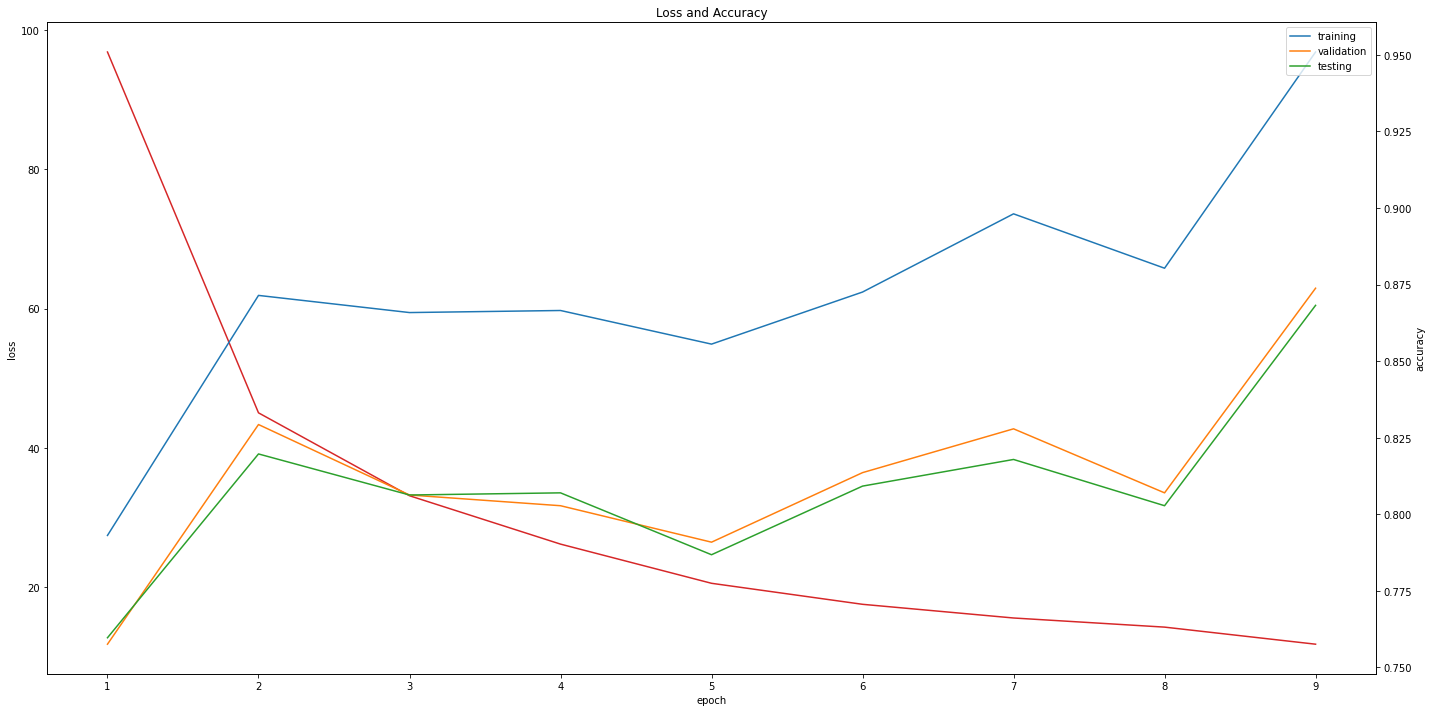

Run 2
--------------------------------------------------------------------------------
Shuffling dataset:   0 > 10000 > 20000 > 30000 > 40000 > 50000	Done!
Model: "model_q1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
resizing_2 (Resizing)           (None, 64, 64, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 70, 70, 3)    0           resizing_2[0][0]                 
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (N

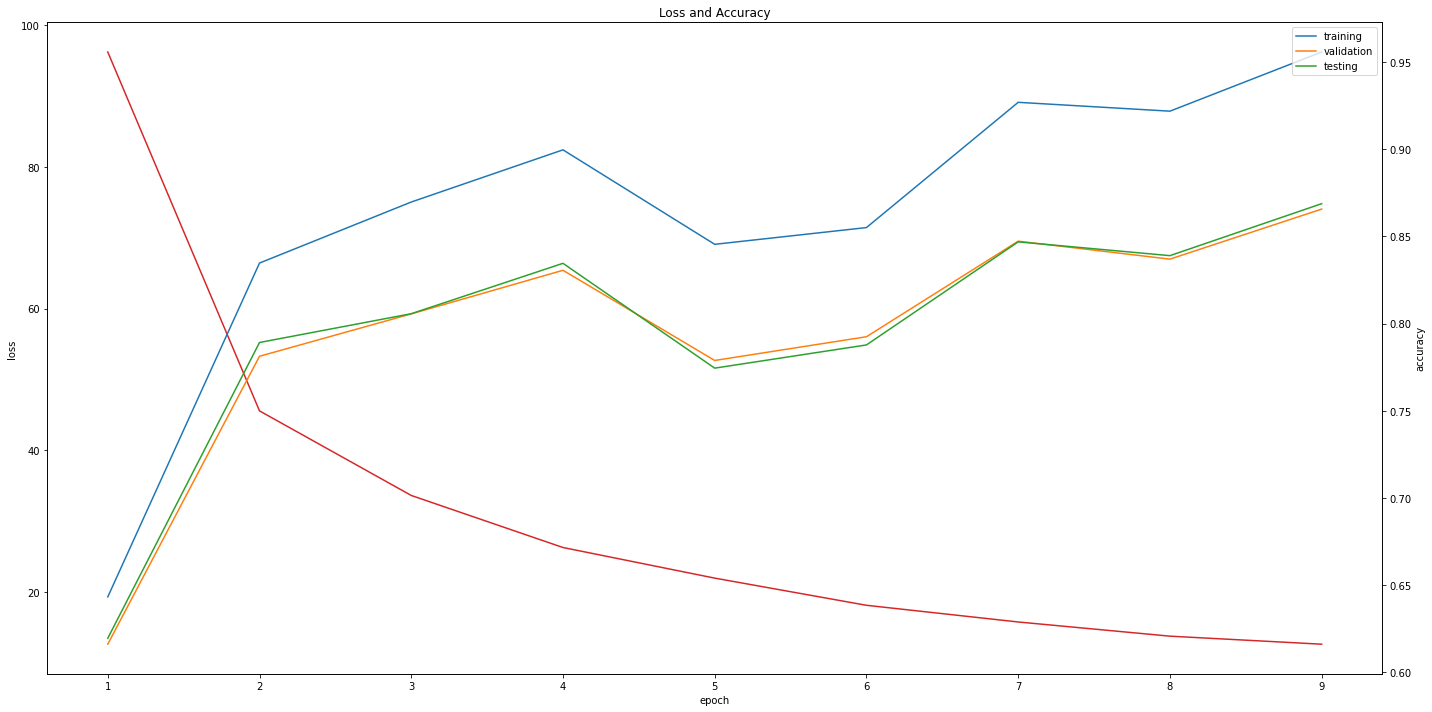

Run 3
--------------------------------------------------------------------------------
Shuffling dataset:   0 > 10000 > 20000 > 30000 > 40000 > 50000	Done!
Model: "model_q1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
resizing_3 (Resizing)           (None, 64, 64, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 3)    0           resizing_3[0][0]                 
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (N

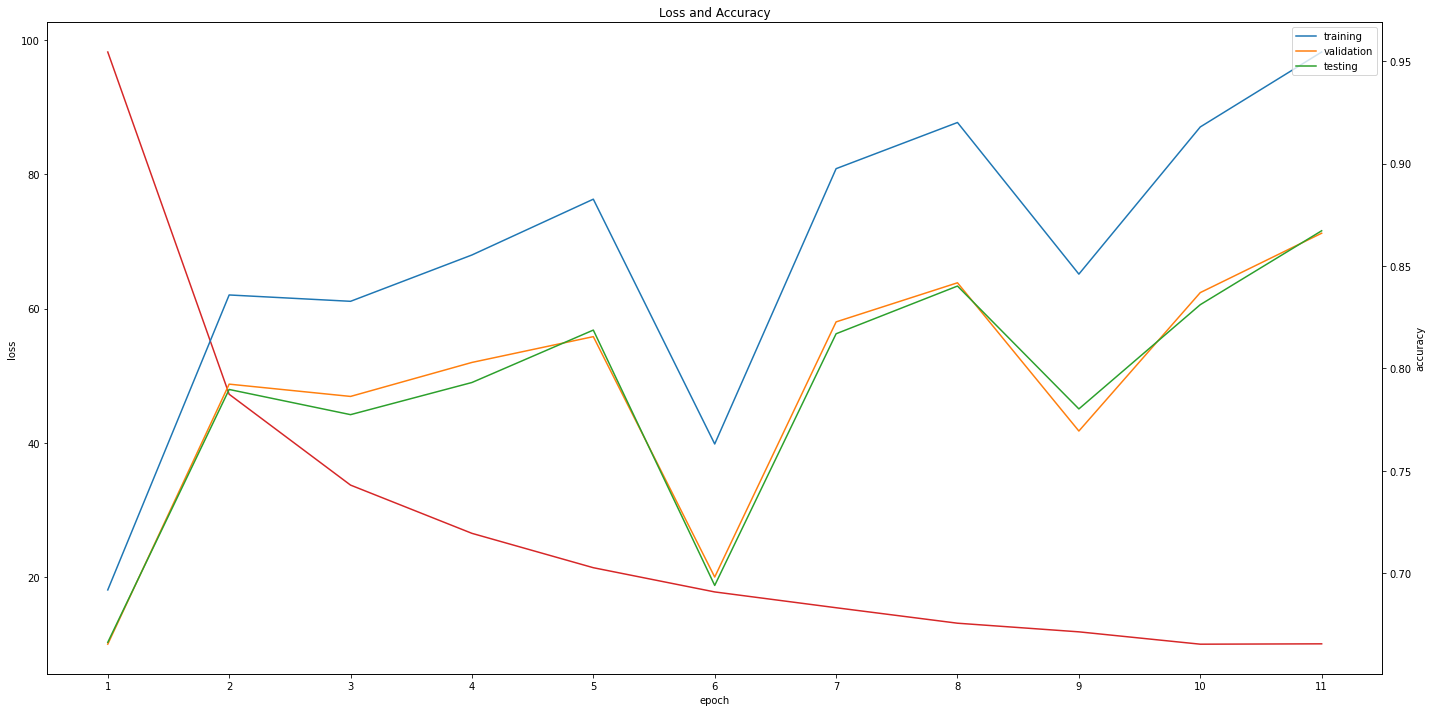

Results
--------------------------------------------------------------------------------
Average Training Accuracy: 0.9537249999999999, Average Validation Accuracy: 0.8685, Average Testing Accuracy: 0.8680666666666667


In [ ]:
# run 3 times
print("Run 1")
print("-"*80)
# prepare the datasets
train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test = prepare_dataset()
# get the model 
model_q1_run1 = get_model_q1()
# train and test
tr_acc_run_1, va_acc_run_1, te_acc_run_1 = train_and_test(model_q1_run1, 1e-3, train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test)

print("Run 2")
print("-"*80)
# prepare the datasets
train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test = prepare_dataset()
# get the model
model_q1_run2 = get_model_q1()
# train and test
tr_acc_run_2, va_acc_run_2, te_acc_run_2 = train_and_test(model_q1_run2, 1e-3, train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test)

print("Run 3")
print("-"*80)
# prepare the datasets
train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test = prepare_dataset()
# get the model
model_q1_run3 = get_model_q1()
# train and test
tr_acc_run_3, va_acc_run_3, te_acc_run_3 = train_and_test(model_q1_run3, 1e-3, train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test)

print("Results")
print("-"*80)
print("Average Training Accuracy: {}, Average Validation Accuracy: {}, Average Testing Accuracy: {}".format((tr_acc_run_1+tr_acc_run_2+tr_acc_run_3)/3, (va_acc_run_1+va_acc_run_2+va_acc_run_3)/3, (te_acc_run_1+te_acc_run_2+te_acc_run_3)/3))


In [ ]:
# load the saved datasets
X_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_train_p2.npy")
y_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_train_p2.npy")
X_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_test_p2.npy")
y_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_test_p2.npy")

# normalize the datasets
X_train = X_train.astype(np.float32) / 255
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32) /255
y_test = y_test.astype(np.float32)

# load the saved model
model_q1 = load_model("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_model_p2q1_.h5")

# obtain the training accuracy
y_pred = model_q1.predict(X_train)
y_pred_classes = [np.argmax(y_p) for y_p in y_pred]

print("For Training Dataset:")
print("Classification Report: \n", classification_report(y_train, y_pred_classes))
print("Training Accuracy =",accuracy_score(y_train, y_pred_classes))
print("Confusion Matrix =\n",confusion_matrix(y_train, y_pred_classes))

# obtain the testing accuracy
y_pred = model_q1.predict(X_test)
y_pred_classes = [np.argmax(y_p) for y_p in y_pred]

print("For Testing Dataset:")
print("Classification Report: \n", classification_report(y_test, y_pred_classes))
print("Testing Accuracy =",accuracy_score(y_test, y_pred_classes))
print("Confusion Matrix =\n",confusion_matrix(y_test, y_pred_classes))

For Training Dataset:
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.98      0.87      0.92      5000
         1.0       0.98      0.97      0.98      5000
         2.0       0.92      0.95      0.93      5000
         3.0       0.96      0.81      0.88      5000
         4.0       0.87      0.97      0.92      5000
         5.0       0.88      0.95      0.91      5000
         6.0       0.98      0.93      0.95      5000
         7.0       0.94      0.97      0.95      5000
         8.0       0.91      0.99      0.95      5000
         9.0       0.97      0.97      0.97      5000

    accuracy                           0.94     50000
   macro avg       0.94      0.94      0.94     50000
weighted avg       0.94      0.94      0.94     50000

Training Accuracy = 0.9368
Confusion Matrix =
 [[4363   10   54   15  110   15    3   44  348   38]
 [   6 4847    1    3    1    9    2    1   27  103]
 [  50    4 4729    9  117   43   15   15

## Task 2  
run the DCNN from Section 2 with the data from Section 1 from scratch, take the average accuracy from 1 runs (test and training)

In [ ]:
def get_model_q2():
  # resize the images before input to the model
  inputs = Input(shape=(32,32,3))
  x = Resizing(64,64,interpolation="bilinear")(inputs)

  # use the pretrained model layers except for the softmax layer
  base_model = DenseNet121(
      include_top = False,
      weights = None,
      input_shape = None,
      input_tensor = x,
  )

  # add 1 FC layer and 1 softmax layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  predictions = Dense(10, activation = 'softmax')(x)
  model_q2 = Model(inputs = inputs, outputs = predictions, name="model_q2")

  model_q2.compile(
      optimizer = Adam(),
      loss='sparse_categorical_crossentropy',
      metrics = ["acc"]   
  )

  # details of the model
  model_q2.summary()

  # # freeze layer 0 to 53
  # for layer in model_q2.layers:
  #   if model_q2.layers.index(layer)<=53:
  #     layer.trainable = False

  # # output the layer information
  # for layer in model_q2.layers:
  #   print(" Layer:{:3d}\tName:{:30s} Trainable: {}".format(model_q2.layers.index(layer),layer.name,layer.trainable))
  return model_q2

Run 1
--------------------------------------------------------------------------------
Shuffling dataset:   0 > 10000 > 20000 > 30000 > 40000 > 50000	Done!
Model: "model_q2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 64, 64, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           resizing[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (N

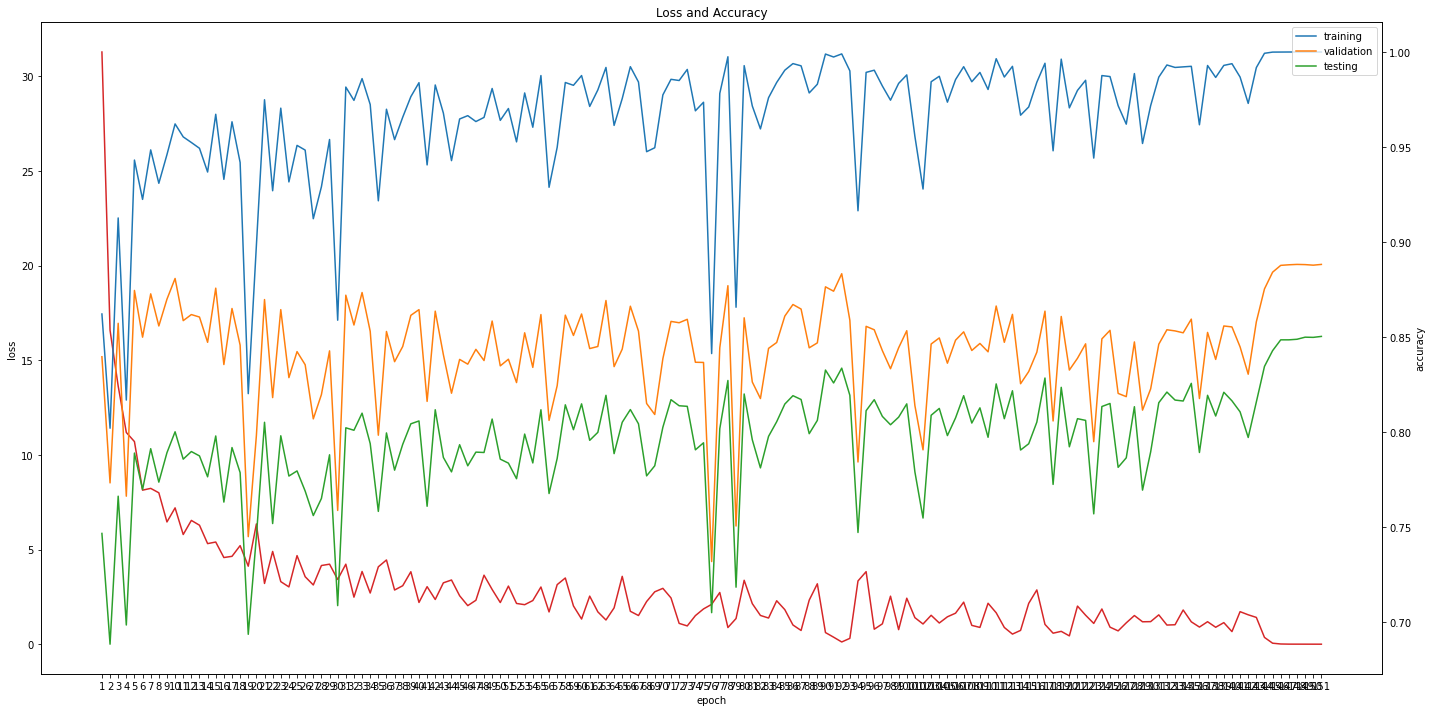

Results
--------------------------------------------------------------------------------
Average Training Accuracy: 1.0, Average Validation Accuracy: 0.8882, Average Testing Accuracy: 0.8503


In [ ]:
# run 1 time
print("Run 1")
print("-"*80)
# prepare the datasets
train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test = prepare_dataset()
# get the model
model_q2_run1 = get_model_q2()
# train and test
tr_acc_run_1, va_acc_run_1, te_acc_run_1 = train_and_test(model_q2_run1, 1e-3, train_dataset, val_dataset, x_train, y_train, x_val, y_val, X_test, y_test)

print("Results")
print("-"*80)
print("Average Training Accuracy: {}, Average Validation Accuracy: {}, Average Testing Accuracy: {}".format(tr_acc_run_1, va_acc_run_1, te_acc_run_1))


In [ ]:
# load the saved datasets
X_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_train_p2.npy")
y_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_train_p2.npy")
X_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_X_test_p2.npy")
y_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_y_test_p2.npy")

# normalize the datasets
X_train = X_train.astype(np.float32) / 255
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32) /255
y_test = y_test.astype(np.float32)

# load the saved model
model_q2 = load_model("/content/drive/MyDrive/Colab Notebooks/data/dl_a2_dataset_p1/dl_a2_model_p2q2_.h5")

# obtain the training accuracy
y_pred = model_q2.predict(X_train)
y_pred_classes = [np.argmax(y_p) for y_p in y_pred]

print("For Training Dataset:")
print("Classification Report: \n", classification_report(y_train, y_pred_classes))
print("Training Accuracy =",accuracy_score(y_train, y_pred_classes))
print("Confusion Matrix =\n",confusion_matrix(y_train, y_pred_classes))

# obtain the testing accuracy
y_pred = model_q2.predict(X_test)
y_pred_classes = [np.argmax(y_p) for y_p in y_pred]

print("For Testing Dataset:")
print("Classification Report: \n", classification_report(y_test, y_pred_classes))
print("Testing Accuracy =",accuracy_score(y_test, y_pred_classes))
print("Confusion Matrix =\n",confusion_matrix(y_test, y_pred_classes))

For Training Dataset:
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      5000
         1.0       0.99      0.99      0.99      5000
         2.0       0.98      0.97      0.97      5000
         3.0       0.96      0.96      0.96      5000
         4.0       0.97      0.98      0.97      5000
         5.0       0.96      0.97      0.96      5000
         6.0       0.98      0.98      0.98      5000
         7.0       0.98      0.98      0.98      5000
         8.0       0.99      0.99      0.99      5000
         9.0       0.98      0.99      0.99      5000

    accuracy                           0.98     50000
   macro avg       0.98      0.98      0.98     50000
weighted avg       0.98      0.98      0.98     50000

Training Accuracy = 0.97764
Confusion Matrix =
 [[4906    1   17   15    8    8    4    6   19   16]
 [   4 4940    4    0    1    2    5    2    7   35]
 [  20    1 4860   33   26   20   28    

## Task 3  
compare the performance gap and training time between the above two conditions. Please explain why you obtained such results, and give a brief discussion about it.  Based on the paper (Rethinking ImageNet Pre-training, ICCV,2019), the ImageNet pretrained model does not improve accuracy unless the target dataset is too small. Did your experimental result support the conclusion?

<font color="blue" size="3">
The three runs of task1 takes 778.511454, 782.245602, and 960.134177 seconds respectively. The average training and testing accuracies are 0.9368 and 0.8672. This is just based on about 10 epochs for each run because the training process is automatically terminated by a threshold of testing accuracy at 0.85. However, the one run of task2 takes 13110.429570 seconds by several times of continuous training due to failure with network or Colab session, and it takes 172 epochs for just one run to achieve a testing accuracy of 0.85. In the same training time, task 1 can achieve better performance if there are more training epochs. However, given enough time, task 2 also achieve the same performance at 0.85 testing accuracy.

The reason is task1 uses the pre-trained model weights that have been trained based on Imagenet pictures. These weights adapt to Cifar10 well because there have already been a lot of similar images in Imagenet dataset. Task 2 trained the DenseNet model architecture with randomly initialized weights from scratch. It takes a long time for the DCNN to update the weights for the hundreds of convolutional layers.

The result supports the conclusion by the paper. Cifar10 is still a small dataset and easy task for the DenseNet model. For the small dataset, ImageNet weights can easily boost the accuracy to a very high level because ImageNet weights speed up convergence.
However, for larger datasets, I don't think there will be much difference between the final accuracy between task 1 and 2 if time allows and the dataset is large enough.
</font>

## Task 4  
compare the performance gap and training time between your results (training from scratch) and your results in the Home Assignment 2 Part I. Explain why you obtained such results, and give a brief discussion of why the results are different. (hint: Equation (21) in the slides in Week3)

<font color="blue" size="3">
The 3 runs of part 1 took 447.641799, 451.552422, and 449.068409 seconds for 20 epochs of training. The average testing accuracy is 0.5982. However, based on the training experience, it's quite hard to achieve a higher accuracy by these 5 layers. If the individual learning rates for the 5 convolutinal layers can be optimized, it might be able to achieve the 0.85 testing accuracy in a shorter time than what's consumed by Part 2 Task 2.

Though Part 2 Task 2 took a long time, the deep neural network can achieve a very high accuracy with enough training epochs. This is matching the equation 21 of week 3 slides.Based on Equation 21 of Week 3 slides, to have the best approximation, there should be large number of hidden layer. To have a good accuracy of empirical fit to the approximation, for a fixed number of training samples (40000), the hidden layer should be small. Either architecture might be working well for Cifar10 which is a relatively small dataset with 50000 samples. The deep network can extract more patterns but the weights are hard to adjusted to a good condition. The shallow network has fewer layers and the weight values can fit to the samples very well.
</font>